# ACCESS Temp

In [1]:
import intake
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np
import xesmf as xe

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/35847/status,
Dashboard: /proxy/35847/status,Workers: 28
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:32927,Workers: 28
Dashboard: /proxy/35847/status,Total threads: 28
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:38277,Total threads: 1
Dashboard: /proxy/42933/status,Memory: 8.97 GiB
Nanny: tcp://127.0.0.1:41707,


In [4]:
#Importing data

pathsC = np.sort(glob.glob('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/outpu*/ocean/ocean.nc'))
pathsM = np.sort(glob.glob('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath_sofia_ssp126/*/ocean/ocean.nc'))

In [5]:
## Creating shelf mask another way

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [6]:
depth = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean_grid.nc')['ht']
land_mask = (0 * depth).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom5')

In [8]:
#Time variant variables #Can this be condensed?
def preprocess(ds):
    ds = ds[['temp', 'st_ocean','dzt']].sel(yt_ocean=shelf_mask['yt_ocean'], st_ocean=slice(None,500))
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess, chunks = 'auto')

In [9]:
#Time slicing
cont = cont.sel(time=slice('1910-01-01','1919-12-31'))
melt = melt.sel(time=slice('1910-01-01','1919-12-31'))

In [10]:
#Time invariant variables
areaC = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean_grid.nc')['area_t'].sel(xt_ocean=shelf_mask['xt_ocean'])
areaM = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath_sofia_ssp126/output040/ocean/ocean_grid.nc')['area_t'].sel(xt_ocean=shelf_mask['xt_ocean'])

In [11]:
#Cell thickness
tempC = cont['temp']#[120:]
thikC = cont['dzt']#[120:]

In [12]:
#Cell thickness for melt
tempM = melt['temp']
thikM =  melt['dzt']

In [13]:
temp_cont_ave = tempC.weighted(thikC.fillna(0)).mean('st_ocean').where(shelf_mask == 0).weighted(areaC.fillna(0)).mean(['xt_ocean', 'yt_ocean'])

In [14]:
temp_cont_ave = temp_cont_ave.load()

In [15]:
temp_melt_ave = tempM.weighted(thikM.fillna(0)).mean('st_ocean').where(shelf_mask == 0).weighted(areaM.fillna(0)).mean(['xt_ocean', 'yt_ocean'])

In [16]:
temp_melt_ave = temp_melt_ave.load()

In [17]:
#Saving
temp_cont_ave.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/access_temp_C_500shelf_timesliced.nc')
temp_melt_ave.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/access_temp_M_500shelf_timesliced.nc')

In [18]:
#Opening
tempcont_acc = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/access_temp_C_500shelf_timesliced.nc', chunks = 'auto')
temppert_acc = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/access_temp_M_500shelf_timesliced.nc', chunks = 'auto')

Text(0.5, 1.0, 'ACCESS Time Series of Temperature for shelf top 500m')

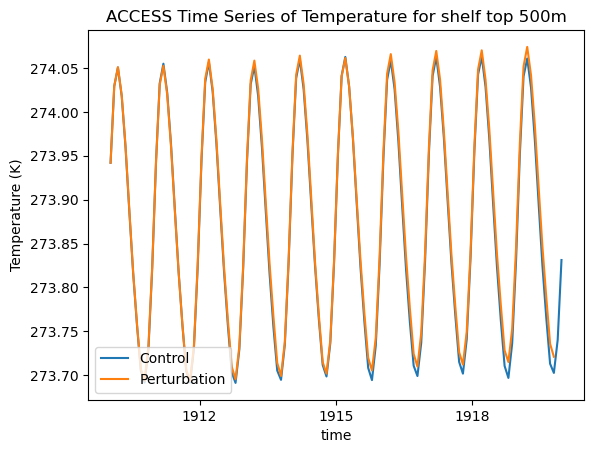

In [19]:
temp_cont_ave.plot(label="Control")
temp_melt_ave.plot(label="Perturbation")
#plt.xlim(380,4000)
#plt.ylim(-1.30,-0.70)
plt.ylabel("Temperature (K)")
plt.legend(loc="lower left")
plt.title("ACCESS Time Series of Temperature for shelf top 500m")

This plot about used time slice restriction, whilst the cell below was using `[120:]` restriction (which gives the same thing, so no need to redo any of the below!).

Text(0.5, 1.0, 'ACCESS Time Series of Temperature for shelf top 500m')

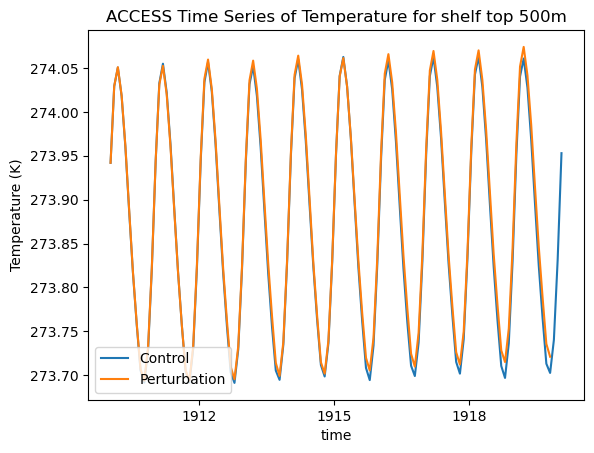

In [60]:
temp_cont_ave.plot(label="Control")
temp_melt_ave.plot(label="Perturbation")
#plt.xlim(380,4000)
#plt.ylim(-1.30,-0.70)
plt.ylabel("Temperature (K)")
plt.legend(loc="lower left")
plt.title("ACCESS Time Series of Temperature for shelf top 500m")

In [31]:
temp_anom_time = temp_melt_ave - temp_cont_ave
temp_anom_time = temp_anom_time.load()

In [32]:
#Saving
temp_anom_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/access_temp_anom_500shelf_time.nc')

## Mapping

In [25]:
tempcont_500 = tempC.sel(st_ocean=slice(0,500)).weighted(thikC['st_ocean'].fillna(0)).mean(dim='st_ocean').mean(dim='time')
temppert_500 = tempM.sel(st_ocean=slice(0,500)).weighted(thikM['st_ocean'].fillna(0)).mean(dim='st_ocean').mean(dim='time')
tempanom_500 = temppert_500 - tempcont_500

In [26]:
tempanom_500 = tempanom_500.load()

In [27]:
import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

In [28]:
land_mask = (0 * depth).fillna(1)
land_50m = cft.NaturalEarthFeature("physical", "land", "50m", edgecolor="black", facecolor="papayawhip", linewidth=0.5)
projection = ccrs.SouthPolarStereo()

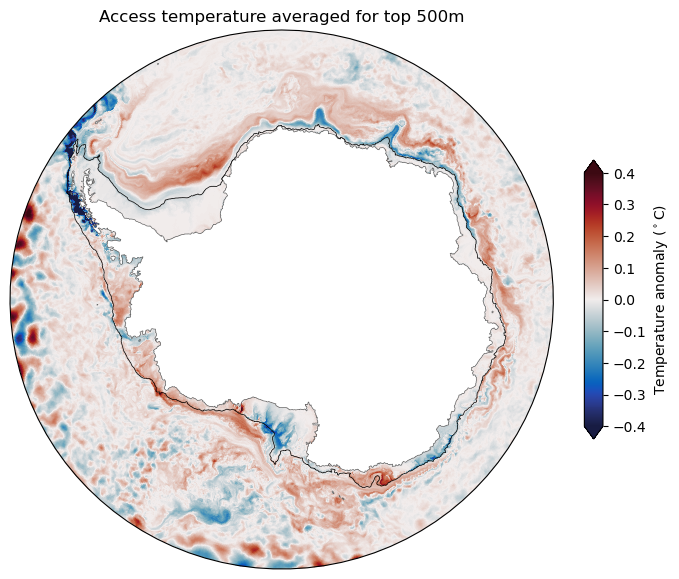

In [37]:
plt.figure(figsize=(8, 7))
ax = plt.axes(projection=projection)

ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())

# Compute a circle in axes coordinates, which we can use as a boundary for the map. 
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.5,transform = ccrs.PlateCarree())

tempanom_500.plot(
    x="xt_ocean",
    y="yt_ocean",
    transform=ccrs.PlateCarree(),
    vmin=-0.4,
    vmax=0.4,
    extend="both",
    cmap=cm.cm.balance, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Temperature anomaly ($^\circ$C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("Access temperature averaged for top 500m");

# Comparing to PanAntarctic 1/10th

In [34]:
tempanom_acc = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/access_temp_anom_500shelf_time.nc', chunks = 'auto')
temppert_01 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/pan01_temp_M_500time.nc', chunks = 'auto')
tempcont_01 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/pan01_temp_C_500time.nc', chunks = 'auto')

In [35]:
tempanom_pan01 = temppert_01 - tempcont_01

Text(0.5, 1.0, 'Time Series of temperature anomaly for shelf top 500m')

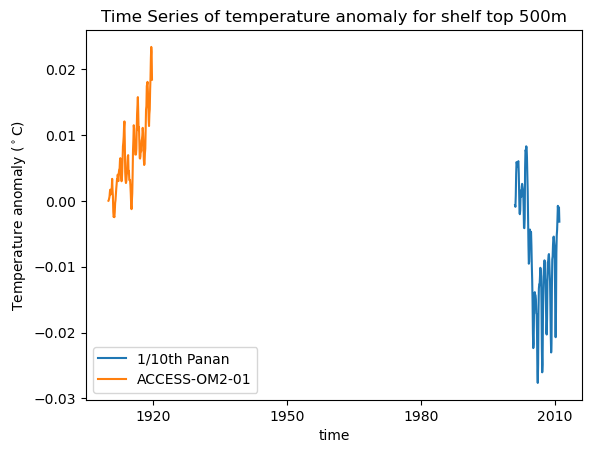

In [36]:
tempanom_pan01.plot(label="1/10th Panan")
tempanom_acc.plot(label="ACCESS-OM2-01")
#plt.xlim(380,4000)
#plt.ylim(-0.03,0.02)
plt.ylabel("Temperature anomaly ($^\circ$C)")
plt.legend(loc="lower left")
plt.title("Time Series of temperature anomaly for shelf top 500m")

In [49]:
tempanom_pan01_new = tempanom_pan01.to_series()
tempanom_acc_new = tempanom_acc.to_series()

In [50]:
import pandas as pd

In [51]:
tempanom_acc_new

time
1910-01-16 12:00:00    0.000031
1910-02-15 00:00:00    0.000153
1910-03-16 12:00:00    0.000397
1910-04-16 00:00:00    0.000702
1910-05-16 12:00:00    0.001404
                         ...   
1919-06-16 00:00:00    0.018707
1919-07-16 12:00:00    0.021667
1919-08-16 12:00:00    0.023407
1919-09-16 00:00:00    0.022644
1919-10-16 12:00:00    0.018433
Name: temp, Length: 118, dtype: float32

In [52]:
tempanom_pan01_new

time
2001-01-16 12:00:00   -0.000651
2001-02-15 00:00:00   -0.000896
2001-03-16 12:00:00    0.000788
2001-04-16 00:00:00    0.004050
2001-05-16 12:00:00    0.005907
                         ...   
2010-08-16 12:00:00   -0.000746
2010-09-16 00:00:00   -0.001664
2010-10-16 12:00:00   -0.002261
2010-11-16 00:00:00   -0.000974
2010-12-16 12:00:00   -0.003149
Name: thetao, Length: 120, dtype: float32

In [54]:
# Make sure index is datetime
#tempanom_pan01_new.index = pd.to_datetime(tempanom_pan01_new.index)
#tempanom_acc_new.index = pd.to_datetime(tempanom_acc_new.index)

# Slice 1910–1918 and 2001–2009
tempanom_acc_new = tempanom_acc_new['1910-01':'1919-10']
tempanom_pan01_new = tempanom_pan01_new['2001-01':'2010-10']

# Reset index to normalized months
tempanom_acc_new.index = range(1, len(tempanom_acc_new)+1)
tempanom_pan01_new.index = range(1, len(tempanom_pan01_new)+1)

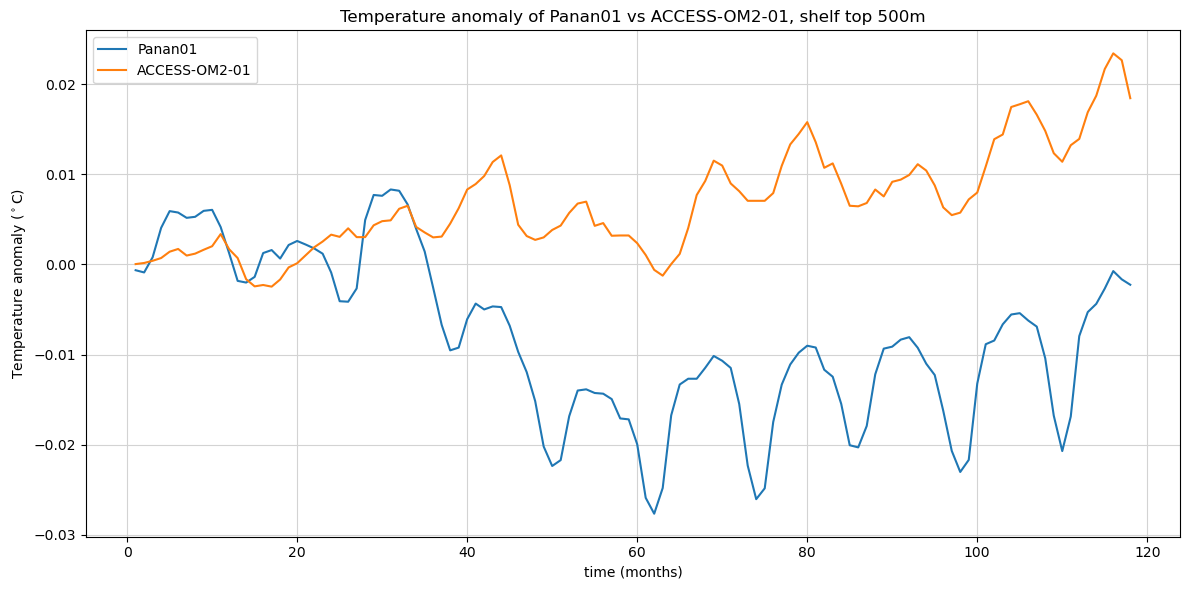

In [59]:
plt.figure(figsize=(12, 6))
plt.plot(tempanom_pan01_new.index, tempanom_pan01_new.values, label='Panan01')
plt.plot(tempanom_acc_new.index, tempanom_acc_new.values, label='ACCESS-OM2-01')
plt.xlabel('time (months)')
plt.ylabel("Temperature anomaly ($^\circ$C)")
plt.title('Temperature anomaly of Panan01 vs ACCESS-OM2-01, shelf top 500m')
plt.legend()
plt.grid(True, color='lightgrey')
plt.tight_layout()
plt.show()